# Importing libraries

In [1]:
import os

from torch import nn
from torch.autograd import grad
import torch

from torch.utils.data import DataLoader
from torch import optim
from torch import autograd
from torch import nn
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import sampler
from argparse import ArgumentParser
#from wgan64x64 import *
from sklearn import metrics
from tqdm.auto import tqdm
import numpy as np
import time
import os
import sys
import random
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt


c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Enabling GPU capabilites

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"]= "max_split_size_mb:21"
key = "PYTORCH_CUDA_ALLOC_CONF"
value = os.getenv(key)

print(value)

max_split_size_mb:21


In [3]:
options_c     = 0 # <- normal class
options_alpha = 1
options_cuda  = '0'
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
        torch.cuda.set_device('cuda:{}'.format(options_cuda))
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

# device2 = torch.device('cuda:{}'.format(options_cuda))
# torch.cuda.set_device('cuda:{}'.format(options_cuda))

cuda:0


# Loading the train, validation and test data sets

In [4]:
MODE = 'wgan-gp'  # Valid options are dcgan, wgan, or wgan-gp

LAMBDA = 10  # Gradient penalty lambda hyperparameter
CRITIC_ITERS = 12  # How many critic iterations per generator iteration
BATCH_SIZE = 5  # Batch size

NOISE_SIZE = 128

In [5]:
DIM = 160
OUTPUT_DIM = 3*160*160

TOP_CROP_POS = 50
LEFT_CROP_POS = 35

In [6]:
def one_class_dataloader(c, nw=0, bs=64):
    nw = 0
    # data_dir = '../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
    # test_dir = '../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
    data_dir = '../../Images/june5Night/Positive'      #This is for the home laptop
    test_dir = '../../Images/june5Night/Evaluation'      #This is for the home laptop

    val_dir = '../../Images/june5Night/Validation/'      #This is for the home laptop
    
    transform = transforms.Compose([
            # transforms.RandomCrop(32, padding=4),
            # transforms.RandomHorizontalFlip(),
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5),
            #                      (0.5, 0.5, 0.5)),
        ])

    dataset = datasets.ImageFolder(data_dir, transform = transform)
    trainloader = DataLoader(
        dataset, bs, num_workers=nw, pin_memory=True, drop_last=True) 
    
    dataset_test = datasets.ImageFolder(test_dir, transform = transform)
    dataloader_test = DataLoader(
        dataset_test, bs, num_workers=nw, pin_memory=True, drop_last=False) 
    
    dataset_val = datasets.ImageFolder(val_dir, transform = transform)
    dataloader_val = DataLoader(
        dataset_val, bs, num_workers=nw, pin_memory=True, drop_last=False) 


    # return trainloader, dataloader_test
    return trainloader, dataloader_test, dataloader_val

# Showing one sample of the training set images

In [7]:
dataloader, _, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)

In [8]:
images, labels = next(iter(dataloader))
images = images.to(device)
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0])
tensor(0.0157, device='cuda:0') tensor(1., device='cuda:0')


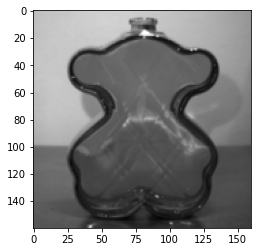

In [9]:
imgs_croped = transforms.functional.crop(images.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
single_img = imgs_croped[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.detach().cpu().numpy()

plt.imshow(single_img_numpy)

# Auxiliar model structures and functions

In [10]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st


class MyConvo2d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True,  stride=1, bias=True):
        super(MyConvo2d, self).__init__()
        self.he_init = he_init
        self.padding = int((kernel_size - 1)/2)
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size,
                              stride=1, padding=self.padding, bias=bias)

    def forward(self, input):
        output = self.conv(input)
        return output


class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(ConvMeanPool, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = self.conv(input)
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        return output


class MeanPoolConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(MeanPoolConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = input
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        output = self.conv(output)
        return output


class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, input_height, input_width, input_depth) = output.size()
        output_depth = int(input_depth / self.block_size_sq)
        output_width = int(input_width * self.block_size)
        output_height = int(input_height * self.block_size)
        t_1 = output.reshape(batch_size, input_height,
                             input_width, self.block_size_sq, output_depth)
        spl = t_1.split(self.block_size, 3)
        stacks = [t_t.reshape(batch_size, input_height,
                              output_width, output_depth) for t_t in spl]
        output = torch.stack(stacks, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(
            batch_size, output_height, output_width, output_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class UpSampleConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True, bias=True):
        super(UpSampleConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init, bias=bias)
        self.depth_to_space = DepthToSpace(2)

    def forward(self, input):
        output = input
        output = torch.cat((output, output, output, output), 1)
        output = self.depth_to_space(output)
        output = self.conv(output)
        return output


class ResidualBlock(nn.Module):
    # ResidualBlock(dim, dim*2, 3, 'down', 64)
    def __init__(self, input_dim, output_dim, kernel_size, resample=None, hw=DIM):
        super(ResidualBlock, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.resample = resample
        self.bn1 = None
        self.bn2 = None
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        if resample == 'down':
            self.bn1 = nn.LayerNorm([input_dim, hw, hw])
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        elif resample == 'up':
            self.bn1 = nn.BatchNorm2d(input_dim)
            self.bn2 = nn.BatchNorm2d(output_dim)
        elif resample == None:
            # TODO: ????
            self.bn1 = nn.BatchNorm2d(output_dim)
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        else:
            raise Exception('invalid resample value')

        if resample == 'down':
            self.conv_shortcut = MeanPoolConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = ConvMeanPool(
                input_dim, output_dim, kernel_size=kernel_size)
        elif resample == 'up':
            self.conv_shortcut = UpSampleConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = UpSampleConv(
                input_dim, output_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                output_dim, output_dim, kernel_size=kernel_size)
        elif resample == None:
            self.conv_shortcut = MyConvo2d(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                input_dim, output_dim, kernel_size=kernel_size)
        else:
            raise Exception('invalid resample value')

    def forward(self, input):
        if self.input_dim == self.output_dim and self.resample == None:
            shortcut = input
        else:
            shortcut = self.conv_shortcut(input)

        output = input
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv_1(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.conv_2(output)

        return shortcut + output


class ReLULayer(nn.Module):
    def __init__(self, n_in, n_out):
        super(ReLULayer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.linear = nn.Linear(n_in, n_out)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.linear(input)
        output = self.relu(output)
        return output





# Building the generator and discriminator models

In [11]:
class FCGenerator(nn.Module):
    def __init__(self, FC_DIM=512):
        super(FCGenerator, self).__init__()
        self.relulayer1 = ReLULayer(128, FC_DIM)
        self.relulayer2 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer3 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer4 = ReLULayer(FC_DIM, FC_DIM)
        self.linear = nn.Linear(FC_DIM, OUTPUT_DIM)
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.relulayer1(input)
        output = self.relulayer2(output)
        output = self.relulayer3(output)
        output = self.relulayer4(output)
        output = self.linear(output)
        output = self.tanh(output)
        return output


class GoodGenerator(nn.Module):
    def __init__(self, dim=DIM, output_dim=OUTPUT_DIM):
        super(GoodGenerator, self).__init__()

        self.dim = dim

        # self.ln1 = nn.Linear(128, 4*4*8*self.dim)
        self.ln1 = nn.Linear(128, 10*10*8*self.dim)
        self.rb1 = ResidualBlock(8*self.dim, 8*self.dim, 3, resample='up')
        self.rb2 = ResidualBlock(8*self.dim, 4*self.dim, 3, resample='up')
        self.rb3 = ResidualBlock(4*self.dim, 2*self.dim, 3, resample='up')
        self.rb4 = ResidualBlock(2*self.dim, 1*self.dim, 3, resample='up')
        self.bn = nn.BatchNorm2d(self.dim)

        self.conv1 = MyConvo2d(1*self.dim, 3, 3)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # print("PEROFORMING __init__")
        self.initialize()

    def initialize(self):
        # print("PEROFORMING INITIALIZATION")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # print("PEROFORMING FORWARD FUNCTION")
        # print("input shape is: ", input.shape)
        output = self.ln1(input.contiguous())
        # print("self.ln1 shape is: ", output.shape)
        # output = output.view(-1, 8*self.dim, 4, 4)
        output = output.view(-1, 8*self.dim, 10, 10)
        # print("output.view shape is: ", output.shape)
        output = self.rb1(output)
        # print("self.rb1 shape is: ", output.shape)
        output = self.rb2(output)
        # print("self.rb2 shape is: ", output.shape)
        output = self.rb3(output)
        # print("self.rb3 shape is: ", output.shape)
        output = self.rb4(output)
        # print("self.rb4 shape is: ", output.shape)

        output = self.bn(output)
        # print("self.bn shape is: ", output.shape)
        output = self.relu(output)
        # print("self.relu shape is: ", output.shape)
        output = self.conv1(output)
        # print("self.conv1 shape is: ", output.shape)
        output = self.tanh(output)
        # print("self.tanh shape is: ", output.shape)
        # print("END OF FORWARD FUNCTION")
        # # output = output.view(-1, OUTPUT_DIM)
        return output


class GoodDiscriminator(nn.Module):
    def __init__(self, dim=DIM):
        super(GoodDiscriminator, self).__init__()

        self.dim = dim

        self.conv1 = MyConvo2d(3, self.dim, 3, he_init=False)
        self.rb1 = ResidualBlock(self.dim, 2*self.dim,
                                 3, resample='down', hw=DIM)
        self.rb2 = ResidualBlock(
            2*self.dim, 4*self.dim, 3, resample='down', hw=int(DIM/2))
        self.rb3 = ResidualBlock(
            4*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/4))
        self.rb4 = ResidualBlock(
            8*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/8))
        # self.ln1 = nn.Linear(4*4*8*self.dim, 1)
        self.ln1 = nn.Linear(10*10*8*self.dim, 1)
        # print("PEROFORMING __init__")
        self.initialize()

    def initialize(self):
        # print("PEROFORMING INITIALIZATION")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def extract_feature(self, input):
        # print("PEROFORMING EXTRACTING FEATURES FUNCTION")
        # print("input shape is: ", input.shape)
        output = input.contiguous()
        # print("input.contigous() shape is: ", output.shape)
        output = output.view(-1, 3, DIM, DIM)
        # print("new shape of output is: ", output.shape)
        output = self.conv1(output)
        # print("after self.conv1, the shape of output is: ", output.shape)
        output = self.rb1(output)
        # print("after self.rb1, the shape of output is: ", output.shape)
        output = self.rb2(output)
        # print("after self.rb2, the shape of output is: ", output.shape)
        output = self.rb3(output)
        # print("after self.rb3, the shape of output is: ", output.shape)
        output = self.rb4(output)
        # print("after self.rb4, the shape of output is: ", output.shape)
        # output = output.view(-1, 4*4*8*self.dim)
        output = output.view(-1, 10*10*8*self.dim)
        # print("after output.view, the shape of output is: ", output.shape)
        # print("END OF THE EXTRACTING FEATURES FUNCTION")  
        return output

    def forward(self, input):
        output = self.extract_feature(input)
        output = self.ln1(output)
        output = output.view(-1)
        # print("PEROFORMING FORWARD")
        return output

# Building the encoder model

In [12]:
class Encoder(nn.Module):
    def __init__(self, dim, output_dim, drop_rate=0.0):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(drop_rate)
        self.conv_in = nn.Conv2d(3, dim, 3, 1, padding=1)
        # self.res1 = ResidualBlock(dim, dim*2, 3, 'down', 64)
        # self.res2 = ResidualBlock(dim*2, dim*4, 3, 'down', 32)
        # self.res3 = ResidualBlock(dim*4, dim*8, 3, 'down', 16)
        # self.res4 = ResidualBlock(dim*8, dim*8, 3, 'down', 8)
        self.res1 = ResidualBlock(dim, dim*2, 3, 'down', 160)
        self.res2 = ResidualBlock(dim*2, dim*4, 3, 'down', 80)
        self.res3 = ResidualBlock(dim*4, dim*8, 3, 'down', 40)
        self.res4 = ResidualBlock(dim*8, dim*8, 3, 'down', 20)
        # self.fc = nn.Linear(4*4*8*dim, output_dim)
        self.fc = nn.Linear(10*10*8*dim, output_dim)


    def forward(self, x):
        # print("PEROFORMING FORWARD FUNCTION")
        # print("x shape is: ", x.shape)
        x = self.dropout(x)
        # print("self.dropout shape is: ", x.shape)
        x = self.conv_in(x)
        # print("self.conv_in shape is: ", x.shape)
        x = self.res1(x)
        # print("self.res1 shape is: ", x.shape)
        x = self.res2(x)
        # print("self.res2 shape is: ", x.shape)
        x = self.res3(x)
        # print("self.res3 shape is: ", x.shape)
        x = self.res4(x)
        # print("self.res4 shape is: ", x.shape)
        x = x.view(x.size(0), -1)
        # print("self.view shape is: ", x.shape)
        x = self.fc(x)
        # print("self.fc shape is: ", x.shape)
        # print("torch.tanh(x) shape is: ", torch.tanh(x).shape)
        return torch.tanh(x)

# Implementing F-AnoGan functions

In [13]:
sys.path.append(os.getcwd())        # Adding to the sys path, the current directory

torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False

In [14]:
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(BATCH_SIZE, int(real_data.nelement()/BATCH_SIZE)).contiguous()
    alpha = alpha.view(BATCH_SIZE, 3, DIM, DIM)
    alpha = alpha.to(device)

    fake_data = fake_data.view(BATCH_SIZE, 3, DIM, DIM)
    interpolates = alpha * real_data.cuda().detach() + ((1 - alpha) * fake_data.detach())           # For home laptop. GPU capabilites
    # interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())                # For work laptop. No GPU
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(
                                  disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty


def wgan_training(PreTrained=False,saveat=1000,genstart=0):
    netG = GoodGenerator().to(device)
    netD = GoodDiscriminator().to(device)
    if PreTrained: 
      print('loading pretrained discriminator-weights '+D_Model+'...')
      netD.load_state_dict(torch.load(D_Model))
      print('loading pretrained generator-weights '+G_Model+'...')
      netG.load_state_dict(torch.load(G_Model))

    #one = torch.FloatTensor([1]).to(device)
    one = torch.tensor(1, dtype=torch.float).to(device)
    mone = one * -1

    optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.0, 0.9))
    optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.0, 0.9))

    dataloader, _, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)
    D_real_list = []
    D_fake_list = []
    D_cost_list = []
    G_cost_list = []
    for iteration in tqdm(range(1+genstart, WGAN_ITERS + 1)):
        #print('WGAN - Iteration:'+str(iteration))
        start_time = time.time()
        ############################
        # (1) Update D network
        ###########################
        for i, (_data, _) in enumerate(dataloader):
            if i == CRITIC_ITERS:
                break
            netD.zero_grad()

            # train with real

            real_data = _data.to(device)
            imgs_croped = transforms.functional.crop(real_data.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)

            D_real = netD(imgs_croped.cuda())
            D_real = D_real.mean()
            D_real.backward(mone)
            D_real_list.append(D_real.item())

            # train with fake
            noise = torch.randn(BATCH_SIZE, NOISE_SIZE)
            noise = noise.to(device)
            fake = netG(noise).detach()
            inputv = fake
            D_fake = netD(inputv)
            D_fake = D_fake.mean()
            D_fake.backward(one)
            D_fake_list.append(D_fake.item())

            # train with gradient penalty
            gradient_penalty = calc_gradient_penalty(netD, imgs_croped.cuda().data, fake.data)
            gradient_penalty.backward()

            # print "gradien_penalty: ", gradient_penalty

            D_cost = D_fake - D_real + gradient_penalty
            D_cost_list.append(D_cost.item())
            Wasserstein_D = D_real - D_fake
            optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()

        noise = torch.randn(BATCH_SIZE, NOISE_SIZE)
        noise = noise.to(device)
        fake = netG(noise)
        G = netD(fake)
        G = G.mean()
        G.backward(mone)
        G_cost = -G
        optimizerG.step()
        G_cost_list.append(G_cost.item())

        # Write logs and save samples

        if iteration % saveat == 0:
            save_image(fake*0.5+0.5, 'BS_10/wgangp/fake_' + num2fixstr(iteration,5) + '.jpg')
            print('Iters:{}, D(real):{}, D(fake):{}, Loss D:{}, Loss G:{}'.format(
                iteration,
                np.mean(D_real_list),
                np.mean(D_fake_list),
                np.mean(D_cost_list),
                np.mean(G_cost_list),)
            )
        if iteration % saveat == 0 and iteration != 0:
            torch.save(netD.state_dict(), 'BS_10/models/netD_' + num2fixstr(iteration,5) + '.pth')
            torch.save(netG.state_dict(), 'BS_10/models/netG_' + num2fixstr(iteration,5) + '.pth')
 

# Implementing the training, validation and evaluation functions

In [15]:
   
def train_encoder(PreTrained=False,saveat=100,genstart=0):
    netG = GoodGenerator().to(device)
    netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
    # netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netG.eval()
    netD = GoodDiscriminator().to(device)
    netD.load_state_dict(torch.load(D_Model))
    # netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netD.eval()
    for p in netD.parameters():
        p.requires_grad = False
    for p in netG.parameters():
        p.requires_grad = False

    dataloader, _ , _= one_class_dataloader(options_c, 0, BATCH_SIZE)

    netE = Encoder(DIM, NOISE_SIZE).to(device)
    if PreTrained:
      netE.load_state_dict(torch.load(E_Model))

    optimizer = optim.Adam(netE.parameters(), 1e-4, (0.0, 0.9))

    crit = nn.MSELoss()
    # torch.cuda.empty_cache()
    total_losses_list= []
    mean_losses_list = []
    for iteration in tqdm(range(1+genstart, ENCODER_ITERS+1)):
        losses = []
        netE.train()
        print("iteration is: ", iteration)
        i=0
        for (x, _) in dataloader:
            x = x.to(device)
            imgs_croped = transforms.functional.crop(x.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
            code = netE(imgs_croped.cuda()) 
            rec_image = netG(code)
            d_input = torch.cat((imgs_croped, rec_image), dim=0)
            f_x, f_gx = netD.extract_feature(d_input).chunk(2, 0)
            loss = crit(rec_image, imgs_croped) + options_alpha * crit(f_gx, f_x.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            total_losses_list.append(loss.item())
            # print(i)
            i=i+1
        mean_losses_list.append(np.mean(losses))
        # print(iteration, np.mean(losses))
        netE.eval()
        rec_image = netG(netE(imgs_croped))
        d_input = torch.cat((imgs_croped, rec_image), dim=0)
        
        if iteration % saveat == 0:
            save_image(d_input*0.5+0.5, 'ForBottlesTrainingsV2/rec/rec_'+num2fixstr(iteration,4)+'.png')
        if iteration % saveat == 0 and iteration != 0:
            torch.save(netE.state_dict(), 'ForBottlesTrainingsV2/models/netE_' + num2fixstr(iteration,5) + '.pth')
    torch.save(netE.state_dict(), 'ForBottlesTrainingsV2/models/netE.pth')
    
    # open file
    with open('ForBottlesTrainingsV2/Encoder_total_losses_list.txt', 'w+') as g:
        # write elements of list
        for items in total_losses_list:
            g.write('%s\n' %items)
        print("total_losses_list written successfully")
    # close the file
    g.close() 


def validate():
    netG = GoodGenerator().to(device)
    netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
    # netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netG.eval()
    netD = GoodDiscriminator().to(device)
    netD.load_state_dict(torch.load(D_Model))                                     #For home laptop, using GPU
    # netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netD.eval()
    netE = Encoder(DIM, NOISE_SIZE).to(device)
    netE.load_state_dict(torch.load(E_Model))                                     #For home laptop, using GPU
    # netE.load_state_dict(torch.load(E_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netE.eval()

    _, _, dataloader = one_class_dataloader(options_c, 0, BATCH_SIZE)
    # crit = nn.MSELoss()
    y_true, y_score = [], []
    in_real, out_real, in_rec, out_rec = [], [], [], []
    with torch.no_grad():
        for (x, label) in tqdm(dataloader):
            bs            = x.size(0)
            x             = x.to(device)
            imgs_croped = transforms.functional.crop(x.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
            rec_image     = netG(netE(imgs_croped))
            d_input       = torch.cat((imgs_croped, rec_image), dim=0)
            idx           = (label == options_c)
            in_real.append(imgs_croped[idx])
            in_rec.append(rec_image[idx])
            idx           = (label != options_c)
            out_real.append(imgs_croped[idx])
            out_rec.append(rec_image[idx])
            f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)
            x0            = imgs_croped.reshape(imgs_croped.size(0),-1)
            x1            = rec_image.reshape([bs, OUTPUT_DIM]) 
            rec_diff      = (x1 - x0)**2
            rec_score     = rec_diff.mean(dim=1)
            feat_diff     = ((f_x - f_gx)**2)
            feat_score    = feat_diff.mean(dim=1)
            outlier_score = rec_score + options_alpha * feat_score
            y_true.append(label)
            y_score.append(outlier_score.cpu())
    in_real = torch.cat(in_real, dim=0)[:32]
    in_rec = torch.cat(in_rec, dim=0)[:32]
    out_real = torch.cat(out_real, dim=0)[:32]
    out_rec = torch.cat(out_rec, dim=0)[:32]
    save_image(torch.cat((in_real, in_rec), dim=0), 'ForBottlesTrainingsV2/non-anomalies_validation.png', normalize=True)
    save_image(torch.cat((out_real, out_rec), dim=0),
               'ForBottlesTrainingsV2/anomalies_validation.png', normalize=True)
    y_score = np.concatenate(y_score)
    y_true = np.concatenate(y_true)
    y_true[y_true != options_c] = -1
    y_true[y_true == options_c] = 1
    print('AUC = ', metrics.roc_auc_score(y_true, -y_score))
    plt.figure()
    plt.hist(y_score[y_true==1], 100, density=True, alpha=0.5, color='blue')
    plt.hist(y_score[y_true==-1], 100, density=True, alpha=0.5, color='red')
    plt.show()
    return y_true, y_score



def evaluate():
    netG = GoodGenerator().to(device)
    netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
    # netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netG.eval()
    netD = GoodDiscriminator().to(device)
    netD.load_state_dict(torch.load(D_Model))                                     #For home laptop, using GPU
    # netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netD.eval()
    netE = Encoder(DIM, NOISE_SIZE).to(device)
    netE.load_state_dict(torch.load(E_Model))                                     #For home laptop, using GPU
    # netE.load_state_dict(torch.load(E_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netE.eval()

    _, dataloader, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)
    # crit = nn.MSELoss()
    y_true, y_score = [], []
    in_real, out_real, in_rec, out_rec = [], [], [], []
    with torch.no_grad():
        for (x, label) in tqdm(dataloader):
            bs            = x.size(0)
            x             = x.to(device)
            imgs_croped = transforms.functional.crop(x.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
            rec_image     = netG(netE(imgs_croped))
            d_input       = torch.cat((imgs_croped, rec_image), dim=0)
            idx           = (label == options_c)
            in_real.append(imgs_croped[idx])
            in_rec.append(rec_image[idx])
            idx           = (label != options_c)
            out_real.append(imgs_croped[idx])
            out_rec.append(rec_image[idx])
            f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)
            x0            = imgs_croped.reshape(imgs_croped.size(0),-1)
            x1            = rec_image.reshape([bs, OUTPUT_DIM]) 
            rec_diff      = (x1 - x0)**2
            rec_score     = rec_diff.mean(dim=1)
            feat_diff     = ((f_x - f_gx)**2)
            feat_score    = feat_diff.mean(dim=1)
            outlier_score = rec_score + options_alpha * feat_score
            y_true.append(label)
            y_score.append(outlier_score.cpu())
    in_real = torch.cat(in_real, dim=0)[:32]
    in_rec = torch.cat(in_rec, dim=0)[:32]
    out_real = torch.cat(out_real, dim=0)[:32]
    out_rec = torch.cat(out_rec, dim=0)[:32]
    save_image(torch.cat((in_real, in_rec), dim=0), 'ForBottlesTrainingsV2/non-anomalies.png', normalize=True)
    save_image(torch.cat((out_real, out_rec), dim=0),
               'ForBottlesTrainingsV2/anomalies.png', normalize=True)
    y_score = np.concatenate(y_score)
    y_true = np.concatenate(y_true)
    y_true[y_true != options_c] = -1
    y_true[y_true == options_c] = 1
    print('AUC = ', metrics.roc_auc_score(y_true, -y_score))
    plt.figure()
    plt.hist(y_score[y_true==1], 100, density=True, alpha=0.5, color='blue')
    plt.hist(y_score[y_true==-1], 100, density=True, alpha=0.5, color='red')
    plt.show()
    return y_true, y_score


# Training WGAN

In [16]:
!mkdir wgangp
!mkdir rec
!mkdir models

A subdirectory or file wgangp already exists.
A subdirectory or file rec already exists.
A subdirectory or file models already exists.


In [17]:
print(torch.cuda.is_available())

True


In [18]:
genstart   = 0 # generación de partida (en caso de existir entrenamiento previo)
G_Model    = 'ForBottlesTrainingsV2/models/netG_' + num2fixstr(genstart,5) + '.pth'
D_Model    = 'ForBottlesTrainingsV2/models/netD_' + num2fixstr(genstart,5) + '.pth'

saveat     = 100   # cada cuantas iteraciones se guarda modelo
WGAN_ITERS = 700  # iteraciones máximas del entrenamiento

pretrained = genstart>0

print(G_Model)
print(D_Model)

ForBottlesTrainingsV2/models/netG_00000.pth
ForBottlesTrainingsV2/models/netD_00000.pth


In [19]:
# wgan_training(PreTrained=pretrained,saveat=saveat,genstart=genstart)

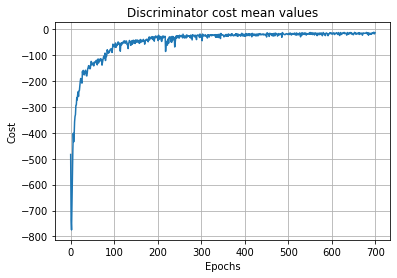

In [20]:
# Load data from the text file
with open("ForBottlesTrainingsV2/D_cost_mean_list.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Discriminator cost mean values")
plt.grid(True)
plt.show()

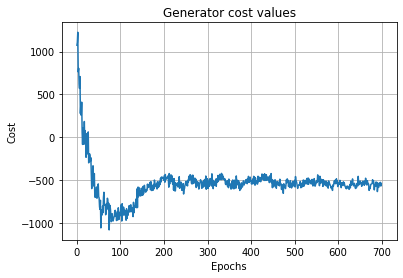

In [21]:
# Load data from the text file
with open("ForBottlesTrainingsV2/G_cost_list.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Generator cost values")
plt.grid(True)
plt.show()

# Training Encoder-Decoder

In [22]:
encstart      = 0
# ENCODER_ITERS = 20
# saveat        = 10 # cada cuantas iteraciones se guarda modelo
ENCODER_ITERS = 50
saveat        = 10 # cada cuantas iteraciones se guarda modelo

gen           = WGAN_ITERS #generación del generator a usar
G_Model       = 'ForBottlesTrainingsV2/models/netG_' + num2fixstr(gen,5) + '.pth'
D_Model       = 'ForBottlesTrainingsV2/models/netD_' + num2fixstr(gen,5) + '.pth'
E_Model       = 'ForBottlesTrainingsV2/models/netE_' + num2fixstr(encstart,5) + '.pth'

pretrained    = encstart>0

print(G_Model)
print(D_Model)
print(E_Model)


ForBottlesTrainingsV2/models/netG_00700.pth
ForBottlesTrainingsV2/models/netD_00700.pth
ForBottlesTrainingsV2/models/netE_00000.pth


In [23]:
# train_encoder(PreTrained=pretrained,saveat=saveat)

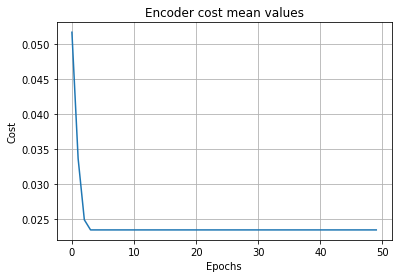

In [24]:
# Load data from the text file
with open("ForBottlesTrainingsV2/Encoder_mean_losses_list.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Encoder cost mean values")
plt.grid(True)
plt.show()

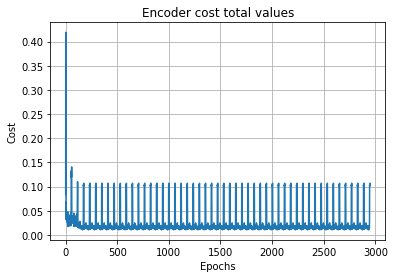

In [25]:
# Load data from the text file
with open("ForBottlesTrainingsV2/Encoder_total_losses_list.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Encoder cost total values")
plt.grid(True)
plt.show()

# Checking the reconstruction of one sample

In [26]:
Ggen    = WGAN_ITERS #generación del generator a usar del generator
Egen    = ENCODER_ITERS #generación a usar del Encoder

G_Model = 'ForBottlesTrainingsV2/models/netG_' + num2fixstr(Ggen,5) + '.pth'
D_Model = 'ForBottlesTrainingsV2/models/netD_' + num2fixstr(Ggen,5) + '.pth'
E_Model = 'ForBottlesTrainingsV2/models/netE.pth'
print(G_Model)
print(D_Model)
print(E_Model)

ForBottlesTrainingsV2/models/netG_00700.pth
ForBottlesTrainingsV2/models/netD_00700.pth
ForBottlesTrainingsV2/models/netE.pth


In [27]:
netG = GoodGenerator().to(device)
netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
# netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netG.eval()
netD = GoodDiscriminator().to(device)
netD.load_state_dict(torch.load(D_Model))                                     #For home laptop, using GPU
# netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netD.eval()
netE = Encoder(DIM, NOISE_SIZE).to(device)
netE.load_state_dict(torch.load(E_Model))                                     #For home laptop, using GPU
# netE.load_state_dict(torch.load(E_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netE.eval()

Encoder(
  (dropout): Dropout(p=0.0, inplace=False)
  (conv_in): Conv2d(3, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res1): ResidualBlock(
    (relu1): ReLU()
    (relu2): ReLU()
    (bn1): LayerNorm((160, 160, 160), eps=1e-05, elementwise_affine=True)
    (bn2): LayerNorm((160, 160, 160), eps=1e-05, elementwise_affine=True)
    (conv_shortcut): MeanPoolConv(
      (conv): MyConvo2d(
        (conv): Conv2d(160, 320, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (conv_1): MyConvo2d(
      (conv): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (conv_2): ConvMeanPool(
      (conv): MyConvo2d(
        (conv): Conv2d(160, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (res2): ResidualBlock(
    (relu1): ReLU()
    (relu2): ReLU()
    (bn1): LayerNorm((320, 80, 80), eps=1e-05, elementwise_affine=True)
    (bn2): LayerNorm((320, 80, 80), eps=1e-05, elementwise_affine=True)
    (conv_shortcut): Mean

In [28]:
dataloader, _, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)

In [29]:
images, labels = next(iter(dataloader))
images = images.to(device)
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0])
tensor(0.0157, device='cuda:0') tensor(1., device='cuda:0')


In [30]:
imgs_croped = transforms.functional.crop(images.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
single_img = imgs_croped[0]


In [31]:
print(single_img.shape)

torch.Size([3, 160, 160])


In [32]:
single_img = single_img[None, :]
print(single_img.shape)

torch.Size([1, 3, 160, 160])


In [33]:
rec_image     = netG(netE(single_img))
d_input       = torch.cat((single_img, rec_image), dim=0)

f_x, f_gx     = netD.extract_feature(d_input).chunk(2, 0)
x0            = single_img.reshape(single_img.size(0),-1)
x1            = rec_image.reshape([1, OUTPUT_DIM]) 
rec_diff      = (x1 - x0)**2
rec_score     = rec_diff.mean(dim=1)
feat_diff     = ((f_x - f_gx)**2)
feat_score    = feat_diff.mean(dim=1)
outlier_score = rec_score + options_alpha * feat_score


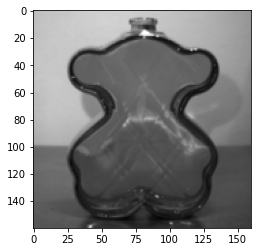

In [34]:
real_img = single_img[0].permute(1, 2, 0) 
single_real_img_numpy = real_img.detach().cpu().numpy()

plt.imshow(single_real_img_numpy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


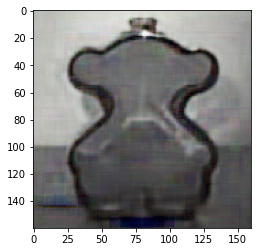

In [35]:
rec_img = rec_image[0].permute(1, 2, 0) 
rec_img_img_numpy = rec_img.detach().cpu().numpy()

plt.imshow(rec_img_img_numpy)

# Validation


In [36]:
Ggen    = WGAN_ITERS #generación del generator a usar del generator
Egen    = ENCODER_ITERS #generación a usar del Encoder

G_Model = 'ForBottlesTrainingsV2/models/netG_' + num2fixstr(Ggen,5) + '.pth'
D_Model = 'ForBottlesTrainingsV2/models/netD_' + num2fixstr(Ggen,5) + '.pth'
E_Model = 'ForBottlesTrainingsV2/models/netE.pth'
print(G_Model)
print(D_Model)
print(E_Model)

ForBottlesTrainingsV2/models/netG_00700.pth
ForBottlesTrainingsV2/models/netD_00700.pth
ForBottlesTrainingsV2/models/netE.pth


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


AUC =  0.835


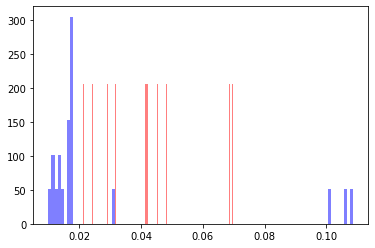

In [37]:
ground_truth, prob_score = validate()

In [42]:
y_true_new = np.copy(ground_truth)
y_true_new[y_true_new==1]=0
y_true_new[y_true_new==-1]=1

In [43]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true_new, prob_score))

AUC =  0.8350000000000001


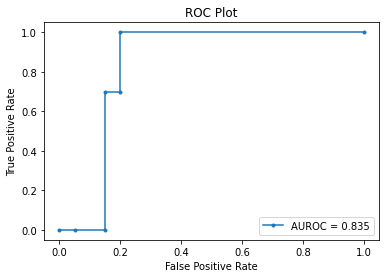

In [44]:
fpr, tpr, thresholds = metrics.roc_curve(y_true_new, prob_score)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true_new, prob_score))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [45]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.05 0.15 0.15 0.2  0.2  1.  ]
The tpr is:  [0.  0.  0.  0.7 0.7 1.  1. ]
The thresholds are:  [1.1085361  0.10853617 0.10116182 0.03152497 0.03096514 0.0211739
 0.01002128]


The best threshold value for this is:  0.0211739  , let's asses this.

In [46]:
def pred_label_onProb(probs_list, prob_threshold):
    pred_based_onProb = []
    for i in range (len(probs_list)):
        if probs_list[i] > prob_threshold:
            prediction = 1                          ## Stands for classifiaction of anomaly bottle
        else:
            prediction = 0
        pred_based_onProb.append(prediction)
    return pred_based_onProb

In [47]:
# from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix

In [48]:
best_threshold_approach1 =0.0211739

In [49]:
conf_matrix = confusion_matrix(y_true_new, pred_label_onProb(prob_score, best_threshold_approach1))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach1)

[[16  4]
 [ 0 10]]
The FPR values are:  0.2
The TPR values are:  1.0
Using the threshold =  0.0211739


# Evaluating the model. With the threhsold value of the direct prob score

100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


AUC =  0.805


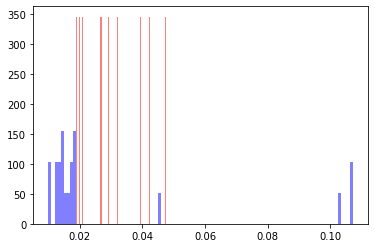

In [50]:
ground_truth, prob_score = evaluate()

In [51]:
y_true_new = np.copy(ground_truth)
y_true_new[y_true_new==1]=0
y_true_new[y_true_new==-1]=1

In [52]:
conf_matrix = confusion_matrix(y_true_new, pred_label_onProb(prob_score, best_threshold_approach1))
print(conf_matrix)
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)
print("Using the threshold = ", best_threshold_approach1)

[[16  4]
 [ 3  7]]
The FPR values are:  0.2
The TPR values are:  0.7
Using the threshold =  0.0211739
